In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()


            # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
            success_counts = [0 for _ in range(10)]
            failure_counts = [0 for _ in range(10)]

            # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
            success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
            failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

            # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
            accuracies = [0 for _ in range(10)]


            # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
            with torch.no_grad():
                for images, labels in test_dataloader:
                    if args.gpu != -1:
                        images, labels = images.to(args.device), labels.to(args.device)

                    outputs = model(images)
                    softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                    predicted_labels = torch.argmax(softmax_probs, dim=1)

                    for i in range(len(labels)):
                        label = labels[i].item()
                        predicted_label = predicted_labels[i].item()
                        prob_vector = softmax_probs[i]

                        if predicted_label == label:
                            # 예측 성공한 경우
                            success_counts[label] += 1
                            success_prob_sums[label] += prob_vector
                            accuracies[label] += 1
                        else:
                            # 예측 실패한 경우
                            failure_counts[label] += 1
                            failure_prob_sums[label] += prob_vector


        # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
        success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
        failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
        classwise_accuracy=[]

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
            classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
            print("Success Probability Vector:")
            print(success_prob_vectors[i])

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")

            print("Failure Probability Vector:")
            print(failure_prob_vectors[i])
        print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 87.10%
Success Probability Vector:
tensor([9.6377e-01, 2.9899e-03, 1.2146e-02, 2.3083e-03, 1.5153e-03, 2.2784e-04,
        3.0475e-04, 1.5954e-03, 1.0050e-02, 5.0938e-03], device='cuda:0')
Class 2 - Accuracy: 92.50%
Success Probability Vector:
tensor([2.8048e-03, 9.7957e-01, 4.3994e-04, 1.7718e-04, 2.1821e-04, 3.7857e-04,
        7.1846e-04, 1.9802e-04, 3.4194e-03, 1.2076e-02], device='cuda:0')
Class 3 - Accuracy: 73.70%
Success Probability Vector:
tensor([6.7955e-03, 5.4859e-04, 9.5840e-01, 7.9338e-03, 6.6811e-03, 6.8857e-03,
        7.1507e-03, 4.3148e-03, 8.0670e-04, 4.8222e-04], device='cuda:0')
Class 4 - Accuracy: 66.30%
Success Probability Vector:
tensor([0.0028, 0.0014, 0.0098, 0.9284, 0.0063, 0.0299, 0.0112, 0.0066, 0.0025,
        0.0011], device='cuda:0')
Class 5 - Accuracy: 77.50%
Success Probability Vector:
tensor([2.2162e-03, 1.5579e-04, 8.5084e-03, 9.2378e-03, 9.5785e-01, 5.717

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 12.869369506835938, Variance = 20.734006881713867, Min = 4.995685577392578, Max = 30.42483139038086
Class 1 (Failed): Mean = 8.541214942932129, Variance = 4.9793219566345215, Min = 4.6089091300964355, Max = 17.50132179260254
Class 2 (Successful): Mean = 20.333602905273438, Variance = 98.09907531738281, Min = 5.810500144958496, Max = 70.93190002441406
Class 2 (Failed): Mean = 10.495994567871094, Variance = 12.224384307861328, Min = 4.657985210418701, Max = 22.20349884033203
Class 3 (Successful): Mean = 11.460291862487793, Variance = 20.910465240478516, Min = 4.596091270446777, Max = 38.23604965209961
Class 3 (Failed): Mean = 8.387312889099121, Variance = 4.881560325622559, Min = 3.695957660675049, Max = 16.587066650390625
Class 4 (Successful): Mean = 9.12198543548584, Variance = 7.612735748291016, Min = 4.083950996398926, Max = 27.01311492919922
Class 4 (Failed): Mean = 8.1815824508667, Variance = 4.211786270141602, Min = 3.774601459503174, Max = 16.53469848

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            print(before_acc_results)

            print ("Before min/max/mean/std of accuracy")
            print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))

                    
                    


Files already downloaded and verified
Files already downloaded and verified
[85.0, 77.0, 88.0, 79.0, 82.0, 81.0, 93.0, 79.0, 80.0, 87.0, 78.0, 84.0, 80.0, 85.0, 83.0, 77.0, 83.0, 85.0, 89.0, 78.0, 85.0, 78.0, 76.0, 84.0, 87.0, 82.0, 83.0, 82.0, 78.0, 81.0, 79.0, 82.0, 86.0, 83.0, 85.0, 86.0, 80.0, 81.0, 83.0, 80.0, 89.0, 81.0, 76.0, 84.0, 79.0, 78.0, 79.0, 75.0, 84.0, 86.0, 82.0, 81.0, 79.0, 81.0, 79.0, 82.0, 79.0, 81.0, 85.0, 84.0, 77.0, 90.0, 79.0, 82.0, 84.0, 83.0, 85.0, 77.0, 84.0, 79.0, 83.0, 82.0, 73.0, 91.0, 84.0, 84.0, 82.0, 84.0, 79.0, 86.0, 83.0, 85.0, 84.0, 80.0, 85.0, 80.0, 80.0, 79.0, 84.0, 80.0, 86.0, 87.0, 80.0, 77.0, 82.0, 78.0, 81.0, 79.0, 85.0, 87.0]
Before min/max/mean/std of accuracy
73.0 93.0 82.08 3.62


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 49, 1: 54, 2: 56, 3: 40, 4: 54, 5: 47, 6: 54, 7: 53, 8: 47, 9: 46}, 1: {0: 46, 1: 52, 2: 45, 3: 42, 4: 59, 5: 45, 6: 53, 7: 64, 8: 41, 9: 53}, 2: {0: 47, 1: 52, 2: 56, 3: 41, 4: 53, 5: 43, 6: 38, 7: 52, 8: 55, 9: 63}, 3: {0: 49, 1: 44, 2: 53, 3: 52, 4: 56, 5: 56, 6: 45, 7: 47, 8: 55, 9: 43}, 4: {0: 50, 1: 54, 2: 49, 3: 54, 4: 45, 5: 53, 6: 55, 7: 47, 8: 53, 9: 40}, 5: {0: 47, 1: 44, 2: 38, 3: 52, 4: 54, 5: 63, 6: 54, 7: 53, 8: 49, 9: 46}, 6: {0: 41, 1: 53, 2: 54, 3: 47, 4: 55, 5: 44, 6: 53, 7: 58, 8: 51, 9: 44}, 7: {0: 58, 1: 44, 2: 49, 3: 42, 4: 63, 5: 45, 6: 60, 7: 43, 8: 55, 9: 41}, 8: {0: 40, 1: 44, 2: 60, 3: 48, 4: 49, 5: 37, 6: 60, 7: 52, 8: 63, 9: 47}, 9: {0: 53, 1: 45, 2: 49, 3: 65, 4: 58, 5: 42, 6: 55, 7: 43, 8: 38, 9: 52}, 10: {0: 54, 1: 54, 2: 46, 3: 42, 4: 41, 5: 53, 6: 54, 7: 54, 8: 50, 9: 52}, 11: {0: 46, 1: 51, 2: 50, 3: 47, 4: 48, 5: 55, 6: 55, 7: 43, 8: 58, 9: 47}, 12: {0: 58, 1: 49, 2: 45, 3: 54, 4: 59, 5:

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 4, 1: 12, 2: 18, 3: 10, 4: 7, 5: 11, 6: 13, 7: 7, 8: 12, 9: 6}, 1: {0: 7, 1: 12, 2: 12, 3: 6, 4: 8, 5: 11, 6: 8, 7: 16, 8: 12, 9: 8}, 2: {0: 10, 1: 11, 2: 8, 3: 13, 4: 6, 5: 10, 6: 12, 7: 8, 8: 9, 9: 13}, 3: {0: 12, 1: 12, 2: 9, 3: 5, 4: 8, 5: 13, 6: 12, 7: 7, 8: 8, 9: 14}, 4: {0: 6, 1: 10, 2: 7, 3: 8, 4: 10, 5: 12, 6: 9, 7: 15, 8: 11, 9: 12}, 5: {0: 9, 1: 13, 2: 9, 3: 9, 4: 14, 5: 8, 6: 18, 7: 6, 8: 7, 9: 7}, 6: {0: 11, 1: 12, 2: 11, 3: 8, 4: 6, 5: 10, 6: 10, 7: 9, 8: 9, 9: 14}, 7: {0: 11, 1: 11, 2: 6, 3: 13, 4: 9, 5: 12, 6: 8, 7: 8, 8: 11, 9: 11}, 8: {0: 12, 1: 9, 2: 10, 3: 7, 4: 16, 5: 13, 6: 8, 7: 7, 8: 8, 9: 10}, 9: {0: 15, 1: 7, 2: 10, 3: 10, 4: 18, 5: 10, 6: 6, 7: 3, 8: 11, 9: 10}, 10: {0: 10, 1: 12, 2: 8, 3: 11, 4: 9, 5: 9, 6: 8, 7: 14, 8: 9, 9: 10}, 11: {0: 11, 1: 11, 2: 13, 3: 11, 4: 6, 5: 12, 6: 10, 7: 13, 8: 9, 9: 4}, 12: {0: 6, 1: 10, 2: 11, 3: 12, 4: 8, 5: 10, 6: 9, 7: 12, 8: 12, 9: 10}, 13: {0: 20, 1: 7, 2: 11

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.2139, -0.4564,  0.1622,  0.2672,  0.4488, -0.0526,  0.0737, -0.2660,
         0.2669, -0.2097], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([3.0394, 2.9732, 2.7982, 2.8340, 3.4323, 2.7499, 3.0013, 2.8417, 3.3041,
        2.8401], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000,  0.0411, -0.0562, -0.2122, -0.1145, -0.3984, -0.2827, -0.1399,
          0.1875,  0.0644],
        [ 0.0411,  1.0000, -0.2707, -0.3140, -0.2767, -0.1436, -0.0822, -0.3017,
          0.0653,  0.3212],
        [-0.0562, -0.2707,  1.0000, -0.0508,  0.0020, -0.0428,  0.0235, -0.0384,
         -0.1744, -0.2323],
        [-0.2122, -0.3140, -0.0508,  1.0000, -0.0470,  0.1921,  0.0243,  0.0194,
         -0.2052, -0.2409],
        [-0.1145, -0.2767,  0.0020, -0.0470,  1.0000, -0.0311,  0.0337,  0.1658,
         -0.1606, -0.4545],
    

Weight norm of each class part of classifier
tensor([1.7434, 1.7243, 1.6728, 1.6834, 1.8526, 1.6583, 1.7324, 1.6857, 1.8177,
        1.6853], device='cuda:0', grad_fn=<SqrtBackward0>)


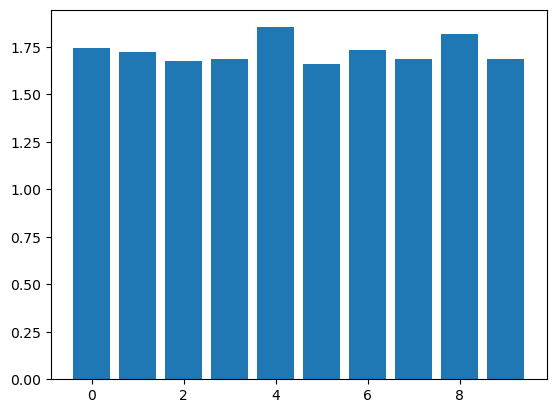

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

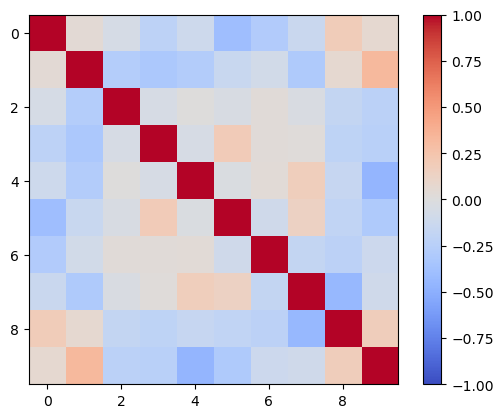

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.8981523, 1: 0.9461719, 2: 0.8547211, 3: 0.83428055, 4: 0.87713635, 5: 0.87128234, 6: 0.9152047, 7: 0.9162513, 8: 0.9347429, 9: 0.92986953}
-------------------VAR-------------------
{0: 0.014218201, 1: 0.010104334, 2: 0.022232324, 3: 0.017722443, 4: 0.017585322, 5: 0.01978531, 6: 0.014271889, 7: 0.014616026, 8: 0.013869978, 9: 0.013557432}


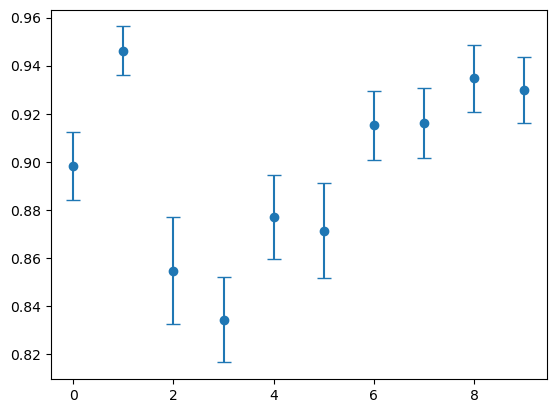

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            net_local_list[0].eval()

            label= [i for i in range(num_classes)]                    


            ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
            class_sums = {i: None for i in label}
            class_counts = {i: None for i in label}



            with torch.no_grad():
                for idx, (images, labels) in enumerate(ldr_test):
                    images, labels = images.to(args.device), labels.to(args.device)
                    features = net_local_list[0].extract_features(images)

                    for i in range(len(label)):
                        class_mask = labels == label[i]  

                        if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                            class_features = features[class_mask]
                            class_sum = class_features.sum(dim=0)
                            count=class_features.shape[0]

                            if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                class_sums[label[i]]=class_sum
                                class_counts[label[i]]=count
                            else:
                                class_sums[label[i]]+=class_sum
                                class_counts[label[i]]+=count

            #Get the class-wise feature centroid                    
            class_mean_dict={}
            for key, value in class_sums.items():
                if key in class_counts:
                    class_mean_dict[key] = value / class_counts[key]

            print(class_mean_dict)
            #Get a Inner product of each class's centroid vector

            sorted_keys=sorted(class_mean_dict)
            print(sorted_keys)

            class_mean_lst=[]


            for key in sorted_keys:
                class_mean_lst.append(class_mean_dict[key])

            class_mean_lst=torch.stack(class_mean_lst)


            print(class_mean_lst.shape)
            print(class_mean_lst.transpose(0,1).shape)

            #Get the each centroid vector's norm
            print("-------------Norm of each centroid vectors --------------")
            print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


            #Get the cosine similarity result between eacn centroid vectors


            normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
            print("-------------Cosine similarity of Each Centroid vectors--------------")
            print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())





Files already downloaded and verified
Files already downloaded and verified
{0: tensor([9.4365e-01, 2.2368e-01, 6.9581e-01, 2.9524e-02, 2.1565e-01, 8.8268e-05,
        6.1814e-01, 1.0857e+00, 1.6060e+00, 8.1030e-05, 1.2047e-01, 3.1494e-02,
        3.1240e-01, 3.8671e-01, 2.4214e-02, 3.8574e-01, 1.2781e+00, 5.3970e-01,
        3.1119e-01, 4.7158e-01, 2.3978e-01, 6.6695e-01, 1.9036e-01, 2.8539e-01,
        4.1865e-01, 3.3395e-01, 5.7981e-01, 1.3734e+00, 6.5695e-01, 2.7665e-02,
        1.3072e-02, 2.5148e-02, 1.0095e+00, 3.8463e-01, 4.2767e-02, 0.0000e+00,
        5.6142e-04, 1.3145e-04, 2.7022e-02, 4.2400e-01, 1.8381e+00, 2.2439e-05,
        6.8706e-04, 3.6528e-01, 9.6875e-02, 6.5031e-01, 5.9185e-01, 2.5564e-01,
        7.0608e-02, 3.0093e-01, 5.6062e-02, 6.8220e-01, 1.9312e-01, 2.2134e-01,
        1.1915e+00, 4.9262e-04, 5.6250e-01, 4.2156e-01, 4.2182e-01, 7.5257e-02,
        1.2567e+00, 2.5128e-02, 0.0000e+00, 6.0532e-02, 2.5600e-02, 2.2643e-02,
        3.6158e-01, 4.7576e-06, 4.1967e-

# Cosine Similarity of Centroid Vectors

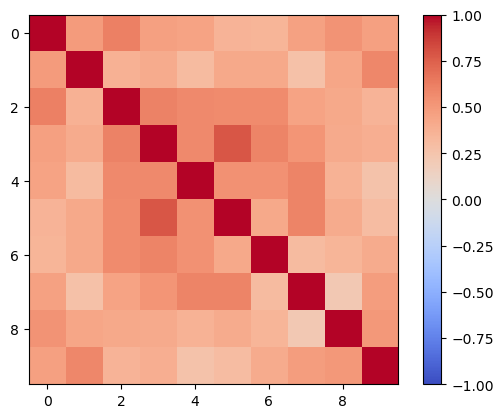

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.9999999  0.4863748  0.6111288  0.4630822  0.45067748 0.35714412
  0.35137406 0.45772916 0.52360123 0.46776247]
 [0.4863748  1.0000002  0.371172   0.39937198 0.3073292  0.42011994
  0.4175016  0.2718628  0.42980546 0.5827046 ]
 [0.6111288  0.371172   1.         0.6019309  0.5752842  0.56523156
  0.565348   0.45224512 0.41665146 0.3524336 ]
 [0.4630822  0.39937198 0.6019309  1.0000001  0.57411516 0.7847182
  0.59448695 0.52106977 0.41299984 0.38741294]
 [0.45067748 0.3073292  0.5752842  0.57411516 1.0000001  0.5332093
  0.53728443 0.5987522  0.36508253 0.26534107]
 [0.35714412 0.42011994 0.56523156 0.7847182  0.5332093  0.9999999
  0.41952658 0.59706724 0.40014726 0.30352968]
 [0.35137406 0.4175016  0.565348   0.59448695 0.53728443 0.41952658
  1.         0.3096071  0.3511952  0.40452683]
 [0.45772916 0.2718628  0.45224512 0.52106977 0.5987522  0.59706724
  0.3096071  0.9999999  0.21571639 0.48164913]
 [0.52360123 0.42980546 0.41665146 0.41299984 0.36508253 0.

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.6359, 0.6676, 0.6216, 0.5843, 0.5920, 0.6542, 0.6215, 0.6370, 0.6226,
        0.6542], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.6359, 0.6676, 0.6216, 0.5843, 0.5920, 0.6542, 0.6215, 0.6370, 0.6226,
        0.6542], device='cuda:0', grad_fn=<DiagonalBackward0>)


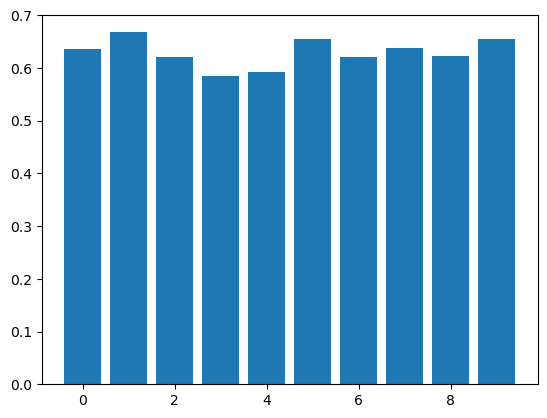

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Singular Value Analysis

Files already downloaded and verified
Files already downloaded and verified
['2.042', '1.942', '1.919', '1.899', '1.844', '1.826', '1.789', '1.541', '1.284', '1.211', '1.107', '1.097', '1.088', '1.078', '1.073', '1.067', '1.062', '1.055', '1.050', '1.046', '1.042', '1.038', '1.031', '1.027', '1.022', '1.021', '1.014', '1.009', '1.003', '1.002', '0.996', '0.995', '0.990', '0.982', '0.979', '0.975', '0.974', '0.971', '0.967', '0.961', '0.960', '0.955', '0.952', '0.949', '0.946', '0.942', '0.939', '0.935', '0.933', '0.930', '0.927', '0.926', '0.921', '0.920', '0.912', '0.910', '0.905', '0.903', '0.899', '0.897', '0.895', '0.893', '0.891', '0.887', '0.885', '0.882', '0.879', '0.878', '0.875', '0.873', '0.866', '0.864', '0.861', '0.858', '0.854', '0.852', '0.851', '0.847', '0.845', '0.841', '0.839', '0.837', '0.835', '0.833', '0.830', '0.828', '0.823', '0.821', '0.819', '0.817', '0.812', '0.810', '0.808', '0.807', '0.806', '0.800', '0.800', '0.797', '0.795', '0.791', '0.791', '0.789', '0.78

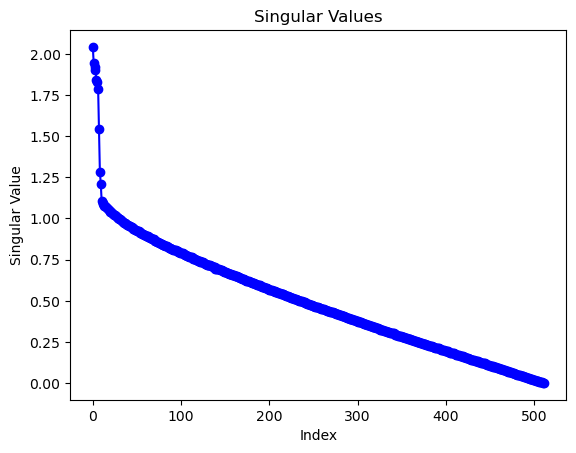

In [18]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.01,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': False
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()

            info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

            # Compute the singular value decomposition (SVD)
            _, s, _ = torch.svd(info_param[0])

            # Sort the singular values in descending order and store them in a list
            sorted_s = sorted(s.tolist(), reverse=True)

            print(["{:.3f}".format(num) for num in sorted_s])

            # Create a list of indices for the singular values
            indices = list(range(len(sorted_s)))

            # Plot the singular values with their indices
            plt.plot(indices, sorted_s, marker='o', linestyle='-', color='b')
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Singular Values')

            # Set x-axis ticks to display only integer values
#                 plt.xticks(indices)

            plt.show()

